In [12]:
import json
import pandas as pd
import itertools
import csv
import string
import pickle
import matplotlib.pyplot as plt

from collections import Counter
import re
import spacy
import nltk
from spacy.lang.en import English
from nltk.util import ngrams
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud
import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
nltk.download('wordnet')
nltk.download('stopwords')

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score

[nltk_data] Downloading package wordnet to /Users/xzhou/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/xzhou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
plt.style.use('seaborn')

In [3]:
pkl_path = '/Users/xzhou/github/project_files/amazon/amazon_alexa_reviews_w_sentiment.pkl'

with open(pkl_path, 'rb') as pkl_file:
    df = pd.read_pickle(pkl_file)

df.head()

rating       date                                             review  \
2       4 2018-07-31  Sometimes while playing a game, you can answer...   
3       5 2018-07-31  I have had a lot of fun with this thing. My 4 ...   
5       5 2018-07-31  I received the echo as a gift. I needed anothe...   
6       3 2018-07-31  Without having a cellphone, I cannot use many ...   
7       5 2018-07-31  I think this is the 5th one I've purchased. I'...   

   sentiment  
2          1  
3          1  
5          1  
6          0  
7          1

In [4]:
# Slice data based on sentiment

df_positive = df[df['sentiment']==1]
df_neutral = df[df['sentiment']==0]
df_negative = df[df['sentiment']==-1]

In [5]:
X = df['review']
X_positive = df_positive['review']
X_neutral = df_neutral['review']
X_negative = df_negative['review']

In [48]:
# Define a topic modeling engine for repetitive use. 
# This can help test out models and identify optimal result.

class TopicModelEngine:
    
    def __init__(self, raw_data):
        self.raw_data = raw_data        
        
    def get_lemma(self, word):
        """
        Get the root words
        """
        try:
            lemma = wn.morphy(word)
        except:
            lemma = word
        return lemma
            
    def tokenize(self, text):
        """
        This is to perform word tokenizing. It performs ngram (1,2)
        """
        lda_tokens = []
        text=text.strip().lower()

        # Extract word portion out of sentence and excludes spaace
        tokenizer = RegexpTokenizer(r'\w+')
        tokens = tokenizer.tokenize(text)
        tokens = [token for token in tokens if (not token.isspace())]

        for token in tokens:
            lda_tokens.append(token)

        # Extract bigrams for additional analysis
        bigrams = ngrams(tokens, 2)

        for bg, count in Counter(bigrams).most_common():
            token_string = []
            token_string = str(bg[0]) + " " + str(bg[1])
            lda_tokens.append(token_string)

        return lda_tokens
    
    def text_processing(self, sentence, stop_words):
        """
        This is to break down text sentence into words, and 
        clean up the words to prepare for LDA modeling.
        """
    
        tokens = self.tokenize(sentence)
        tokens = [word for word in tokens if len(tokens)>5]
        tokens = [word for word in tokens if word not in stop_words]
        tokens = [self.get_lemma(word) for word in tokens]

        return tokens 
    
    def LDA_preprocessing(self, stop_words):
        """
        Provided with raw data, the proprocessing will automatically prepare and
        clean up the data, and generate necessay documents for LDA's use.
        """
        self.text_data = []

        for line in self.raw_data:
            tokens = self.text_processing(line, stop_words)
            tokens=[token for token in tokens if token is not None]
            self.text_data.append(tokens)
        
        self.dictionary = corpora.Dictionary(self.text_data)
        self.corpus = [self.dictionary.doc2bow(text) for text in self.text_data]

    def LDA_model(self, num_of_topics, num_passes, stop_words, file_name_to_save_as):
        """
        This is to perform topic modeling and save the model under the name
        user provides
        """
        self.LDA_preprocessing(stop_words)
        num_topics = num_of_topics
        self.lda = LdaModel(corpus=self.corpus,  num_topics=num_topics, 
                       id2word=self.dictionary, passes=num_passes) 
        self.lda.save(file_name_to_save_as)
        
        return self.lda
    
    def print_topics(self, num_of_words):
        """
        Print out topics for users's decision making. 
        User can specify number of words to print out
        """
        topics = self.lda.print_topics(num_words=num_of_words)
        for topic in topics:
            print('Topic ' + str(topic[0]+1)+': '+str(topic[1]))
            
    def word_cloud(self, num_of_topics):
        for topic in range(num_of_topics):
            plt.figure(figsize=(14,8))
            plt.imshow(WordCloud().fit_words(dict(self.lda.show_topic(topic, 200))))
            plt.axis("off")
            plt.title("Topic #" + str(topic))
            plt.show()

In [85]:
# Default stop_words
stop_words = set(stopwords.words('English'))

In [86]:
# Default stop words are provided by nltk
# Additional words to exlude. Those words don't contain meaningful information. 
# They were identified during multiple iternations

additional_words_to_exclude = set(['get', 'one', 'say', 'still', 'amazon', 'try', 
                                   'need', '34', '2', '3', 'echo', 'dot', 'even', 
                                   'really', 'also', 'like', 'go', 'try', 'thing', 
                                   'tings', 'another','maybe','around', 'usually',
                                   'however','device', 'may', 'little', 'add', 'thank',
                                   'good'])

In [87]:
total_words_to_exclude = stop_words.union(additional_words_to_exclude)

In [90]:
# Case 1: identify top 10 negative topics

topics_neg10 = TopicModelEngine(X_negative)
lda_neg10 = topics_neg10.LDA_model(num_of_topics=10, 
                                   num_passes=20,
                                   stop_words=total_words_to_exclude,
                                   file_name_to_save_as='topics_neg10')
topics_neg10.print_topics(num_of_words=10)


Topic 1: 0.027*"connect" + 0.014*"try" + 0.013*"better" + 0.012*"product" + 0.009*"want" + 0.009*"command" + 0.008*"working" + 0.008*"work" + 0.007*"voice" + 0.007*"return"
Topic 2: 0.012*"back" + 0.012*"buy" + 0.011*"work" + 0.010*"try" + 0.010*"use" + 0.009*"disappoint" + 0.009*"know" + 0.008*"find" + 0.008*"make" + 0.008*"first"
Topic 3: 0.014*"connection" + 0.011*"junk" + 0.011*"work" + 0.010*"internet" + 0.009*"item" + 0.008*"understand" + 0.008*"back" + 0.008*"time" + 0.007*"phone" + 0.007*"disappoint"
Topic 4: 0.034*"work" + 0.014*"stop" + 0.012*"month" + 0.012*"product" + 0.012*"use" + 0.012*"working" + 0.011*"time" + 0.011*"return" + 0.010*"answer" + 0.010*"times"
Topic 5: 0.038*"music" + 0.019*"play" + 0.016*"use" + 0.015*"speaker" + 0.013*"buy" + 0.009*"product" + 0.009*"want" + 0.008*"devices" + 0.008*"home" + 0.008*"pay"
Topic 6: 0.027*"connect" + 0.014*"phone" + 0.012*"google" + 0.012*"buy" + 0.010*"ask" + 0.010*"question" + 0.009*"work" + 0.009*"know" + 0.008*"say" + 0.0

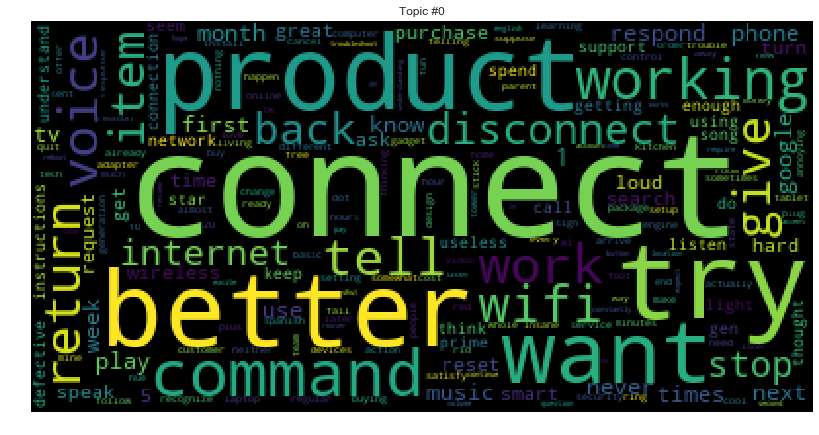

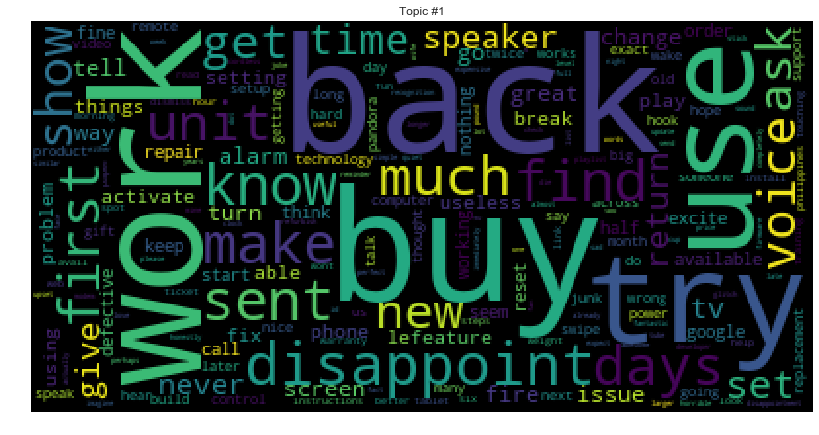

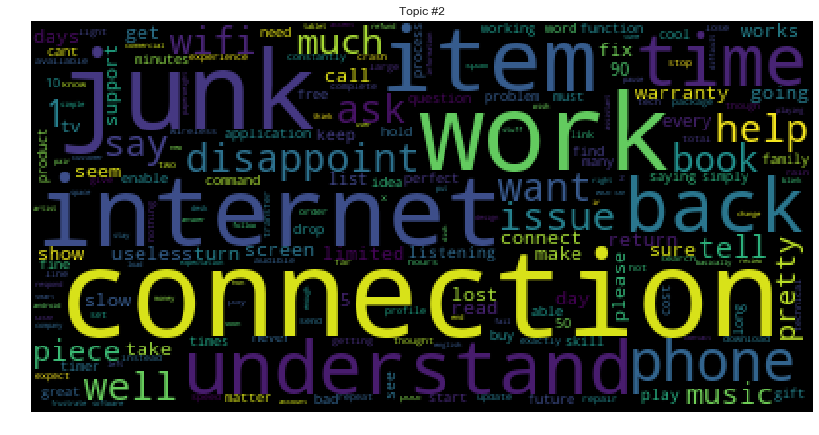

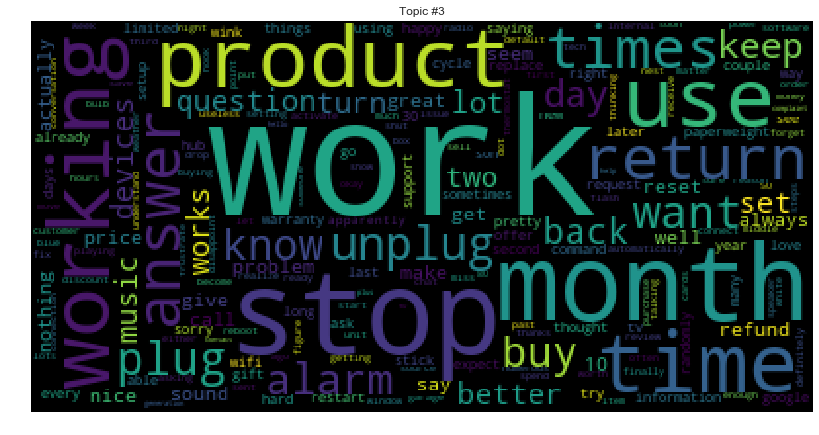

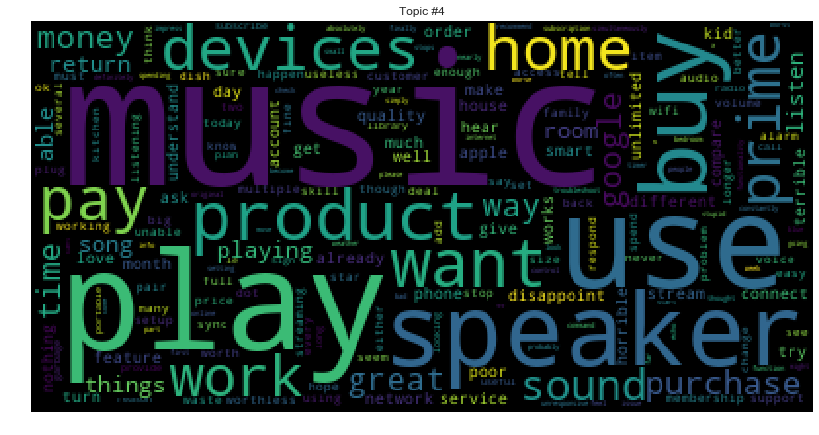

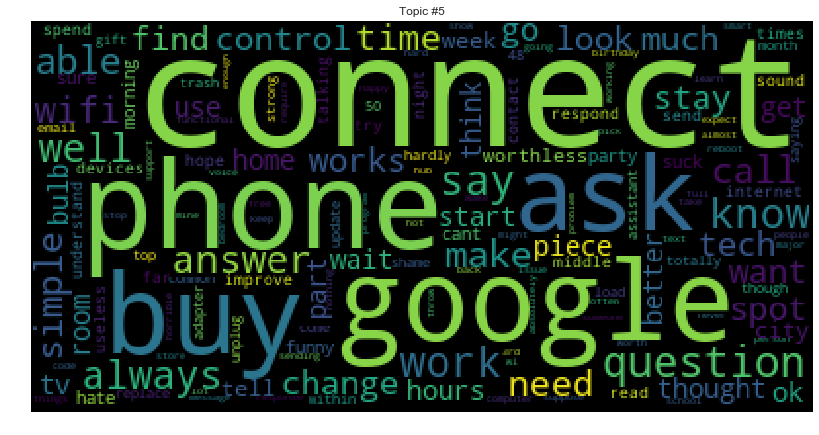

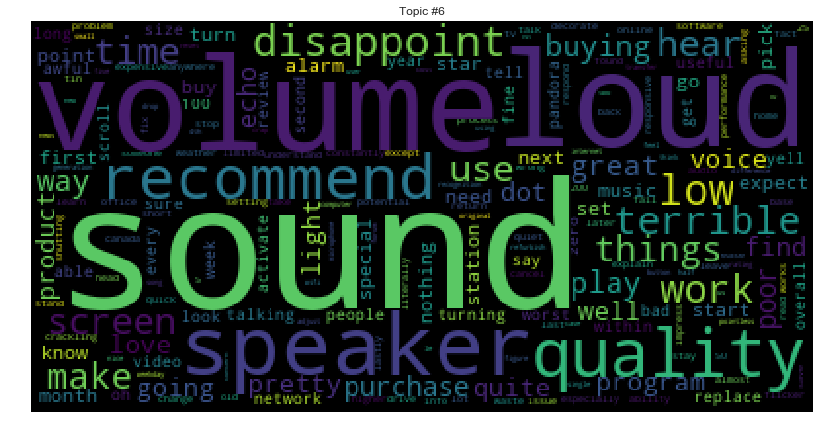

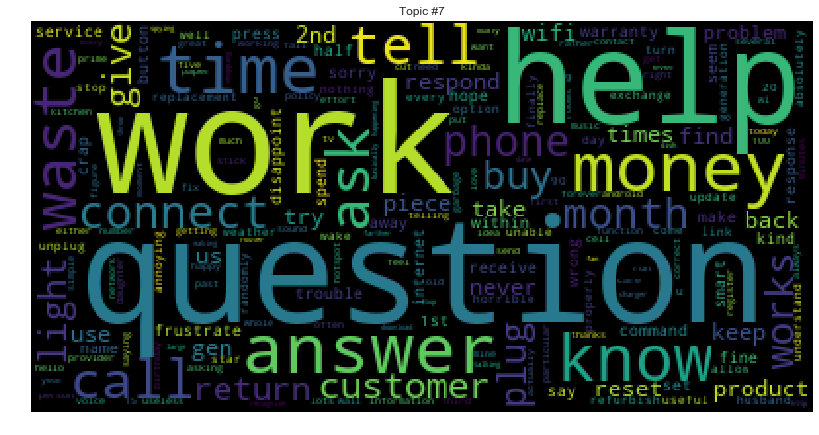

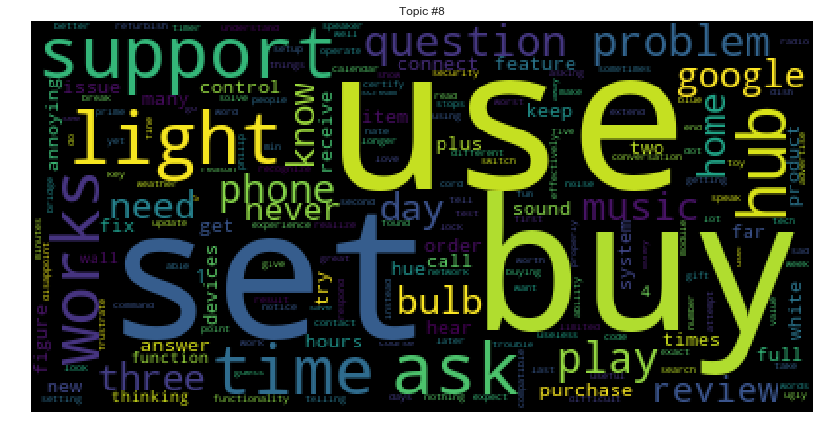

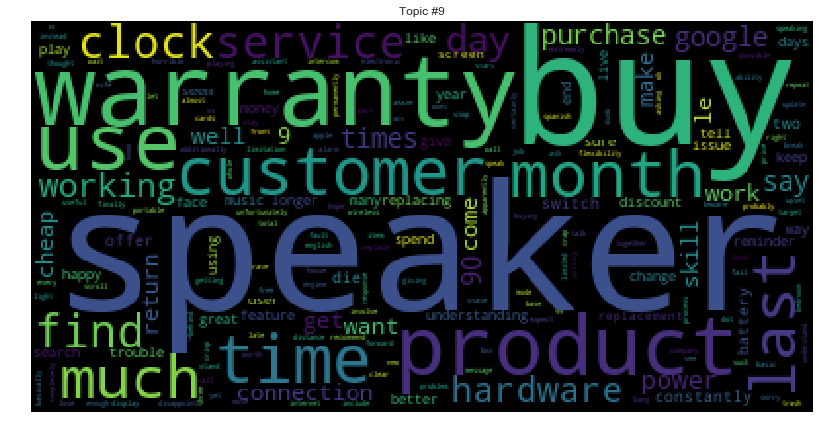

In [91]:
topics_neg10.word_cloud(num_of_topics=10)

In [92]:
# Case 2: identify top 15 negative topics

topics_neg15 = TopicModelEngine(X_negative)
lda_neg15 = topics_neg15.LDA_model(num_of_topics=15, 
                                   num_passes=20,
                                   stop_words=total_words_to_exclude,
                                   file_name_to_save_as='topics_neg15')
topics_neg15.print_topics(num_of_words=10)



Topic 1: 0.027*"music" + 0.021*"speaker" + 0.019*"use" + 0.017*"google" + 0.014*"buy" + 0.013*"home" + 0.011*"product" + 0.009*"return" + 0.009*"play" + 0.009*"set"
Topic 2: 0.042*"connect" + 0.025*"buy" + 0.021*"wifi" + 0.014*"work" + 0.011*"return" + 0.011*"network" + 0.009*"alarm" + 0.009*"working" + 0.009*"use" + 0.008*"clock"
Topic 3: 0.020*"music" + 0.017*"use" + 0.016*"play" + 0.013*"make" + 0.012*"time" + 0.011*"alarm" + 0.009*"buy" + 0.008*"works" + 0.008*"product" + 0.007*"screen"
Topic 4: 0.022*"want" + 0.020*"music" + 0.017*"volume" + 0.015*"play" + 0.014*"loud" + 0.013*"money" + 0.012*"work" + 0.011*"much" + 0.010*"sound" + 0.009*"know"
Topic 5: 0.017*"work" + 0.016*"customer" + 0.015*"use" + 0.015*"month" + 0.014*"working" + 0.013*"warranty" + 0.013*"play" + 0.013*"call" + 0.012*"product" + 0.010*"buy"
Topic 6: 0.012*"music" + 0.011*"white" + 0.009*"work" + 0.009*"play" + 0.009*"time" + 0.008*"black" + 0.008*"limited" + 0.007*"ask" + 0.007*"screen" + 0.007*"order"
Topic 7

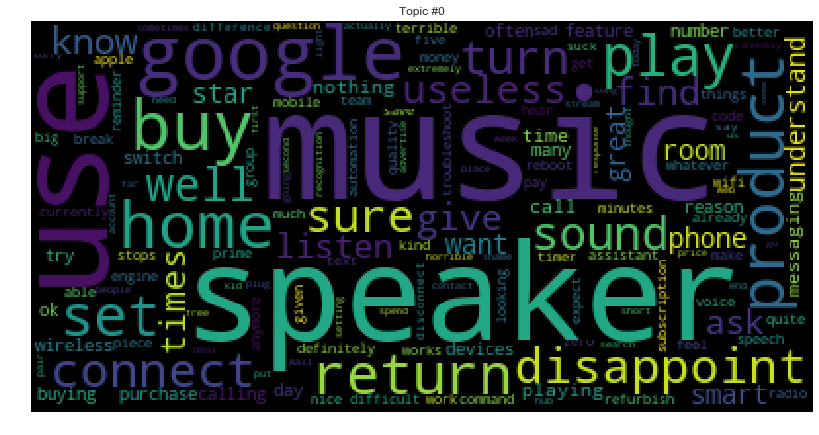

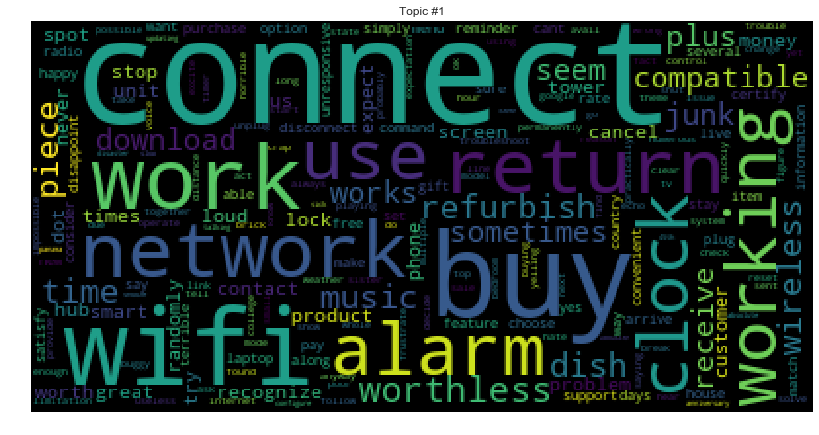

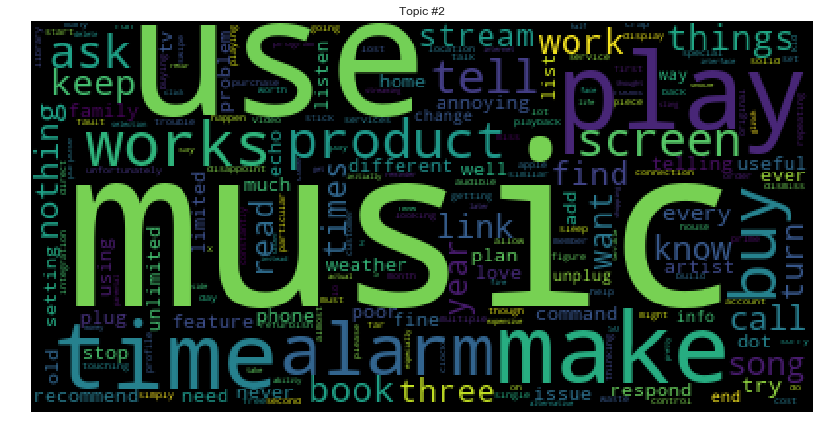

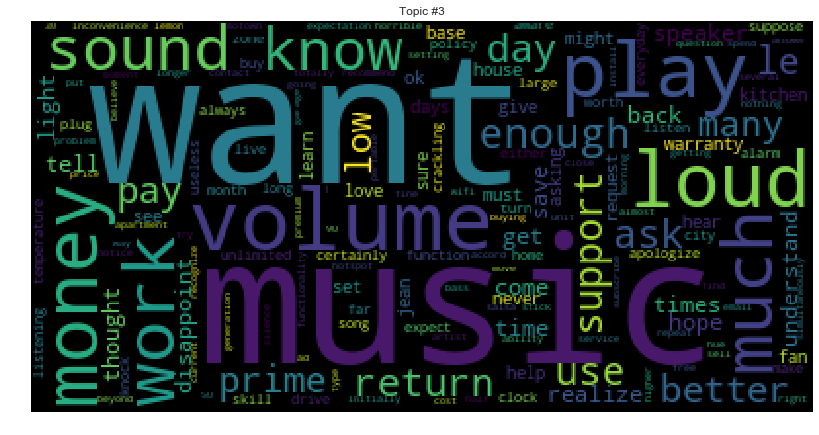

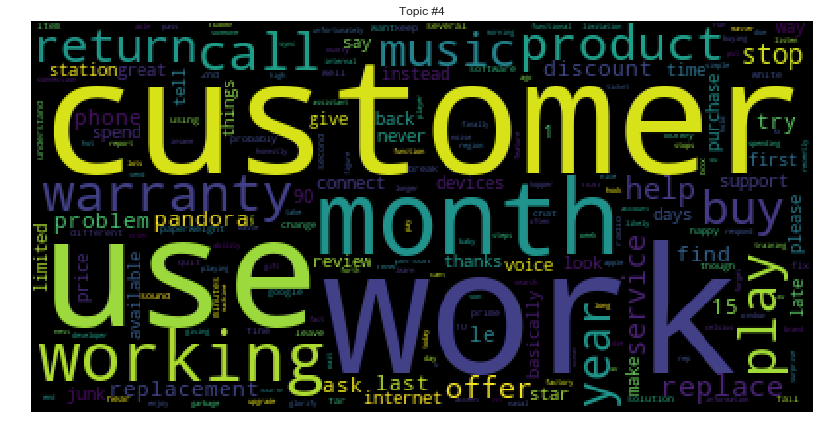

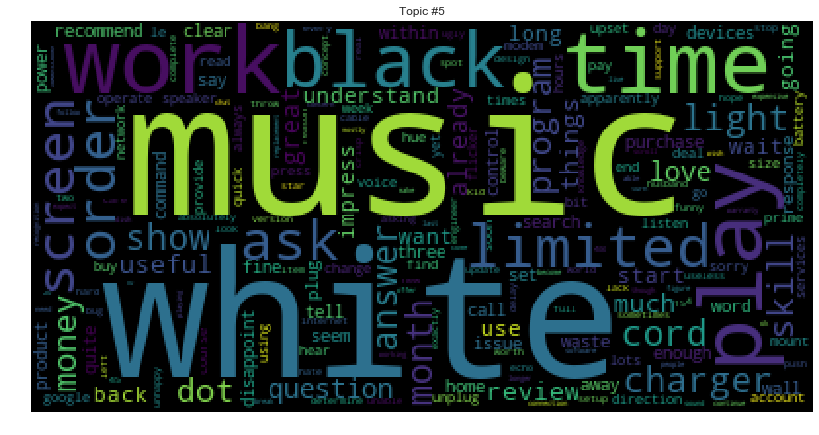

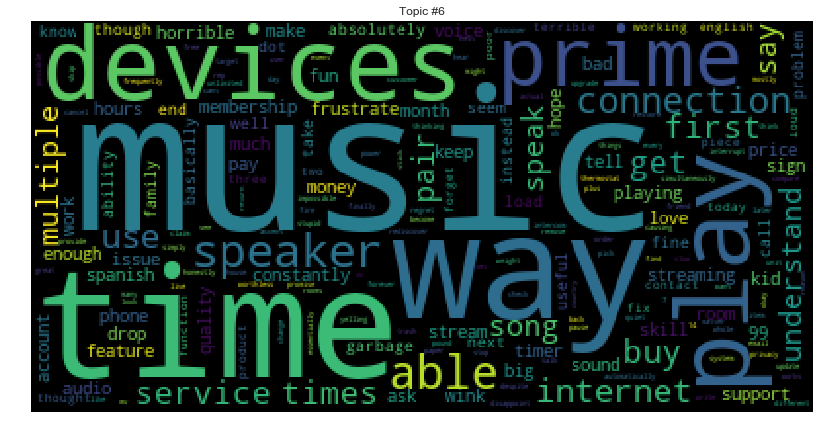

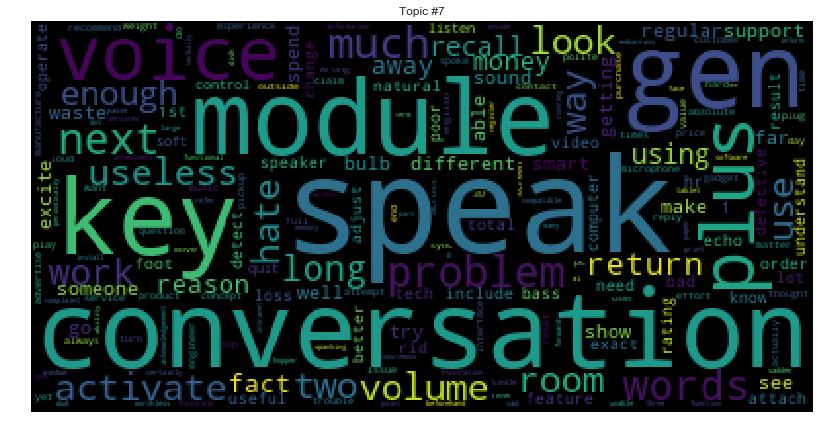

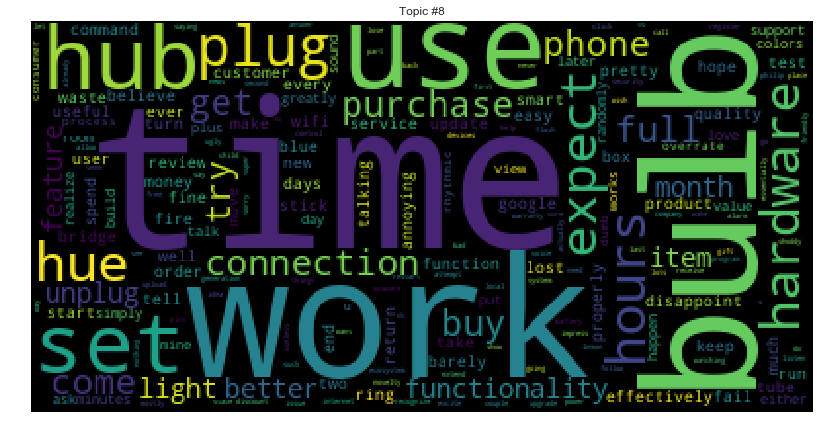

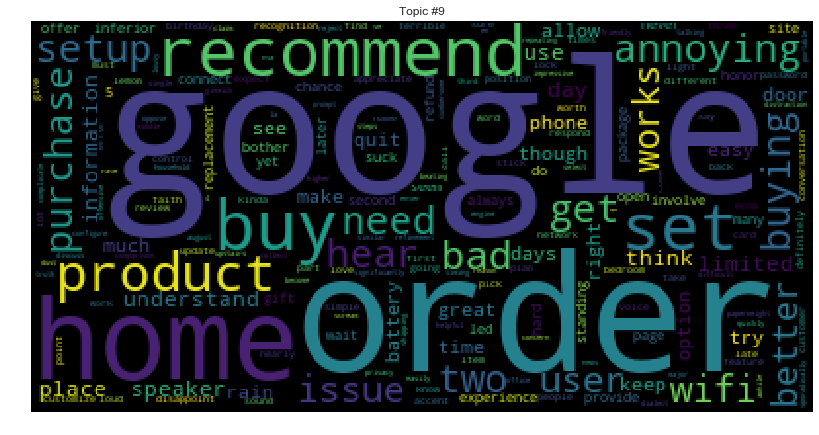

In [93]:
topics_neg15.word_cloud(num_of_topics=10)

In [96]:
# Case 3: identify top 10 positive topics

topics_pos10 = TopicModelEngine(X_positive)
lda_pos10 = topics_pos10.LDA_model(num_of_topics=10, 
                                   num_passes=20, 
                                   stop_words=total_words_to_exclude,
                                   file_name_to_save_as='topics_pos10')
topics_pos10.print_topics(num_of_words=10)

Topic 1: 0.084*"fun" + 0.045*"use" + 0.044*"love" + 0.030*"enjoy" + 0.028*"much" + 0.027*"great" + 0.025*"learning" + 0.022*"far" + 0.022*"lot" + 0.022*"cool"
Topic 2: 0.148*"great" + 0.101*"works" + 0.081*"product" + 0.032*"love" + 0.022*"well" + 0.020*"recommend" + 0.019*"expect" + 0.018*"sound" + 0.013*"excellent" + 0.013*"highly"
Topic 3: 0.014*"use" + 0.014*"phone" + 0.013*"connect" + 0.013*"voice" + 0.012*"home" + 0.010*"feature" + 0.009*"know" + 0.009*"question" + 0.008*"well" + 0.008*"music"
Topic 4: 0.055*"light" + 0.043*"smart" + 0.035*"home" + 0.030*"control" + 0.029*"turn" + 0.022*"tv" + 0.021*"devices" + 0.014*"house" + 0.014*"love" + 0.013*"make"
Topic 5: 0.072*"music" + 0.048*"love" + 0.044*"play" + 0.030*"weather" + 0.024*"ask" + 0.019*"question" + 0.019*"news" + 0.017*"list" + 0.015*"tell" + 0.013*"great"
Topic 6: 0.073*"speaker" + 0.038*"sound" + 0.022*"great" + 0.016*"better" + 0.016*"quality" + 0.015*"room" + 0.014*"music" + 0.012*"connect" + 0.012*"loud" + 0.012*"w

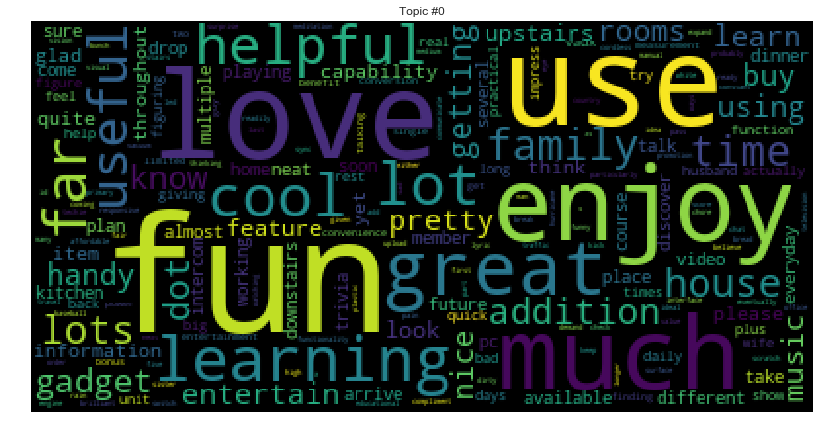

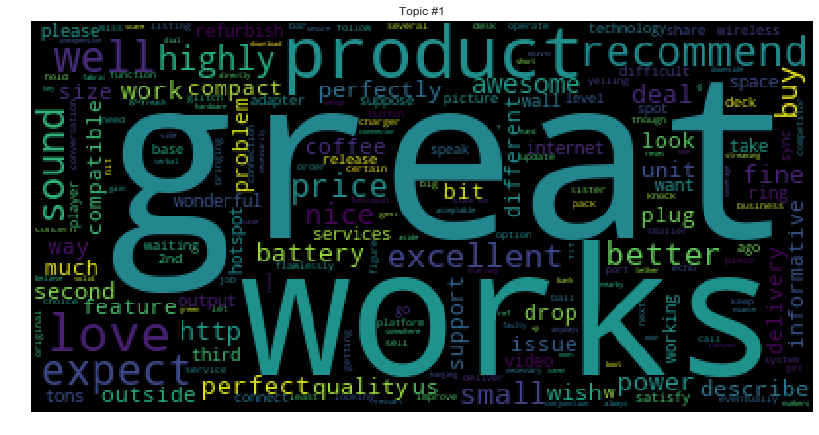

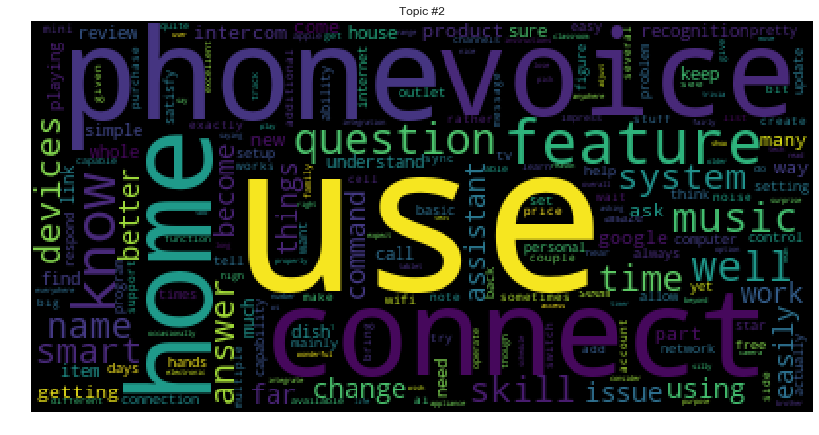

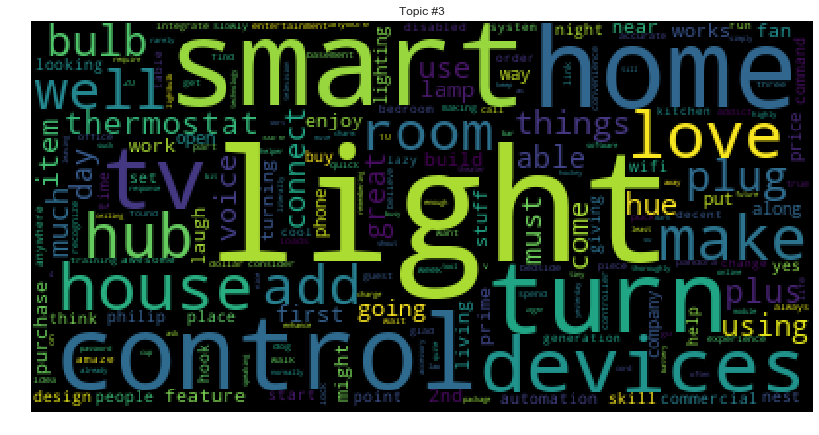

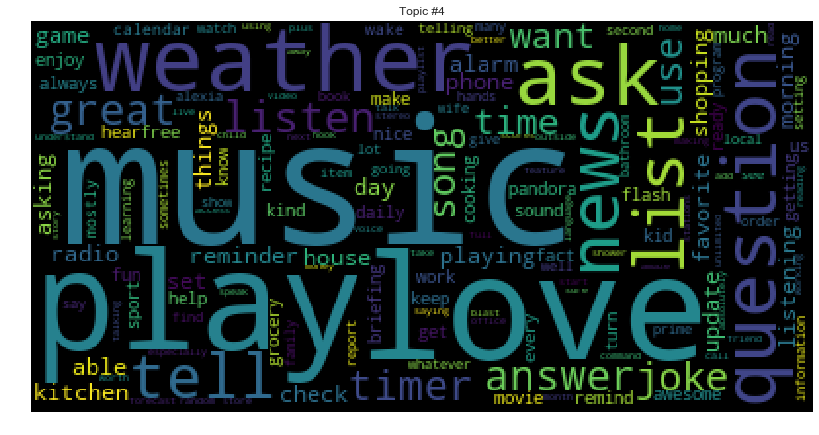

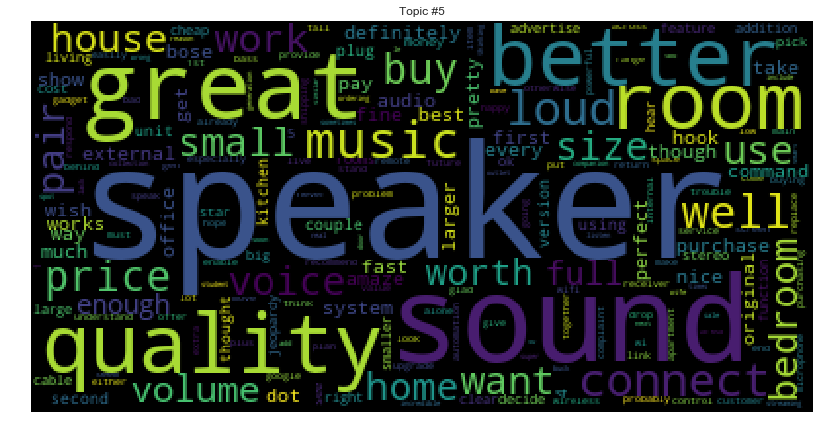

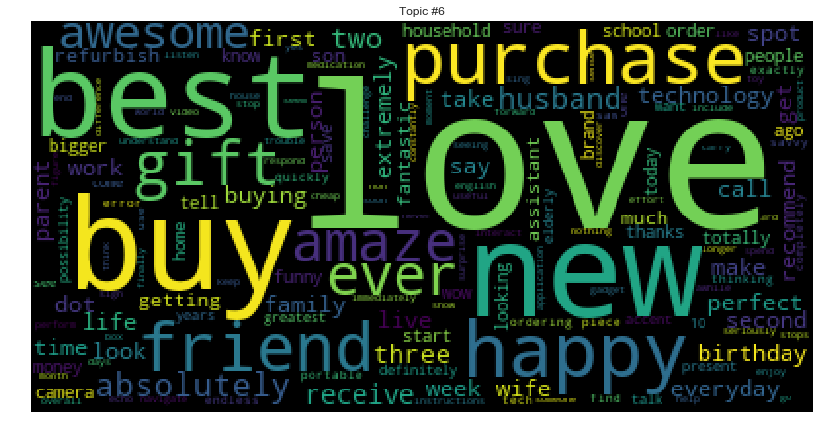

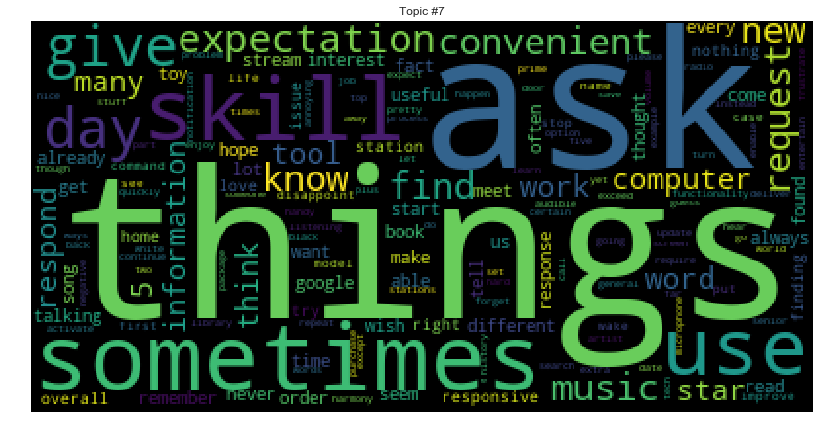

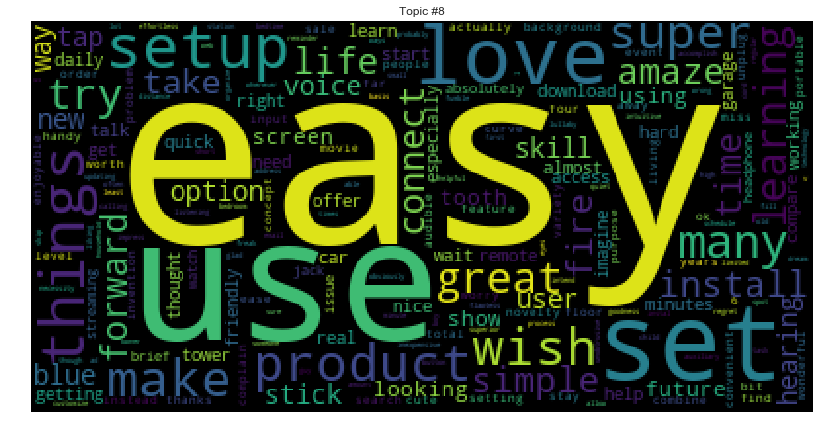

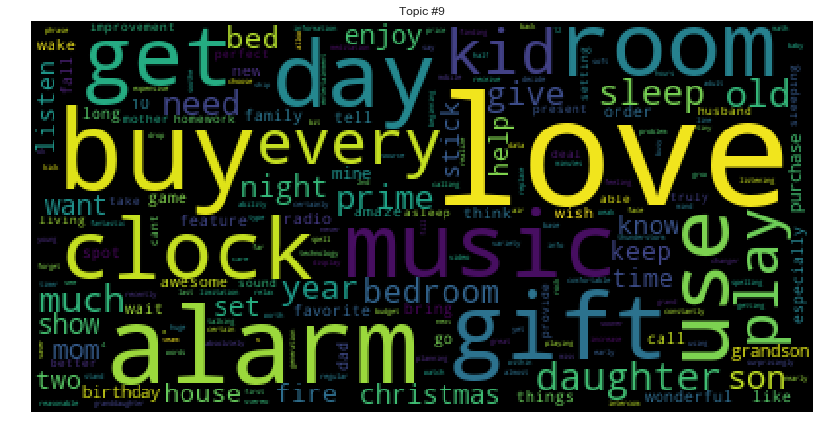

In [97]:
topics_pos10.word_cloud(num_of_topics=10)

In [98]:
# Case 4: identify top 15 positive topics

topics_pos15 = TopicModelEngine(X_positive)
lda_pos15 = topics_pos15.LDA_model(num_of_topics=15, 
                                   num_passes=20, 
                                   stop_words=total_words_to_exclude,
                                   file_name_to_save_as='topics_pos15')
topics_pos15.print_topics(num_of_words=10)

Topic 1: 0.093*"home" + 0.054*"smart" + 0.037*"devices" + 0.026*"easy" + 0.021*"setup" + 0.020*"product" + 0.018*"google" + 0.018*"amaze" + 0.017*"use" + 0.017*"connect"
Topic 2: 0.043*"light" + 0.027*"control" + 0.025*"new" + 0.021*"smart" + 0.021*"connect" + 0.017*"hub" + 0.016*"plug" + 0.016*"turn" + 0.015*"plus" + 0.015*"work"
Topic 3: 0.055*"music" + 0.033*"use" + 0.032*"alarm" + 0.030*"room" + 0.027*"love" + 0.024*"play" + 0.020*"weather" + 0.018*"house" + 0.018*"light" + 0.016*"set"
Topic 4: 0.222*"love" + 0.086*"easy" + 0.074*"use" + 0.051*"set" + 0.021*"buy" + 0.021*"new" + 0.020*"awesome" + 0.020*"friend" + 0.018*"best" + 0.017*"fire"
Topic 5: 0.030*"make" + 0.023*"different" + 0.022*"easy" + 0.021*"use" + 0.017*"voice" + 0.013*"link" + 0.011*"many" + 0.010*"install" + 0.010*"things" + 0.010*"great"
Topic 6: 0.072*"works" + 0.065*"love" + 0.050*"great" + 0.033*"gift" + 0.029*"buy" + 0.025*"well" + 0.016*"get" + 0.016*"work" + 0.015*"son" + 0.013*"purchase"
Topic 7: 0.137*"gre

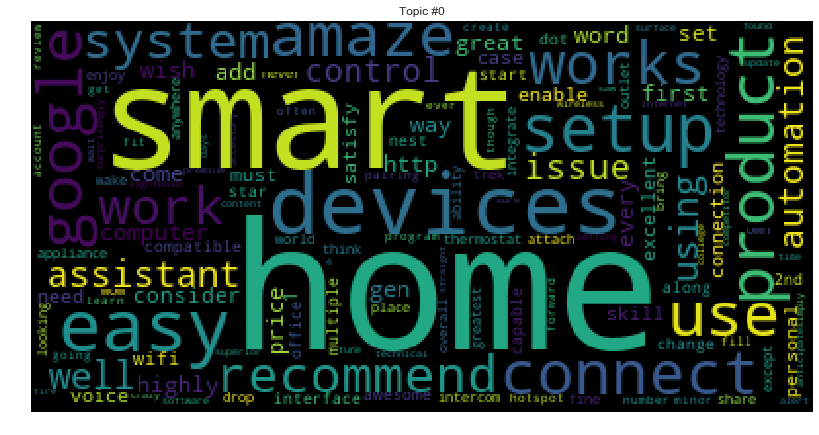

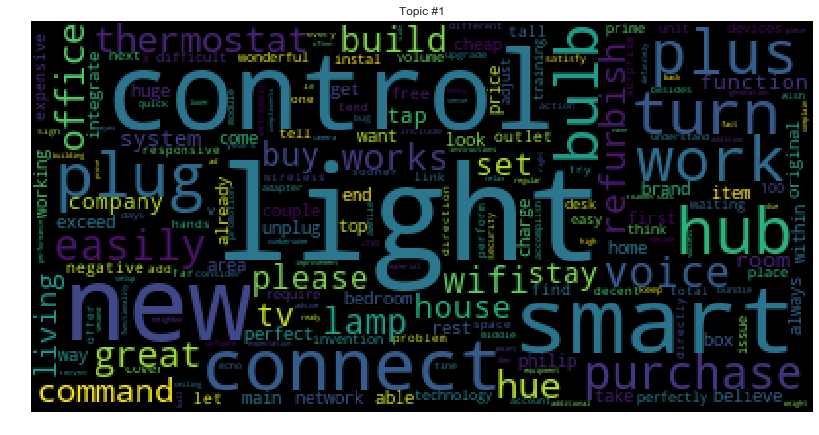

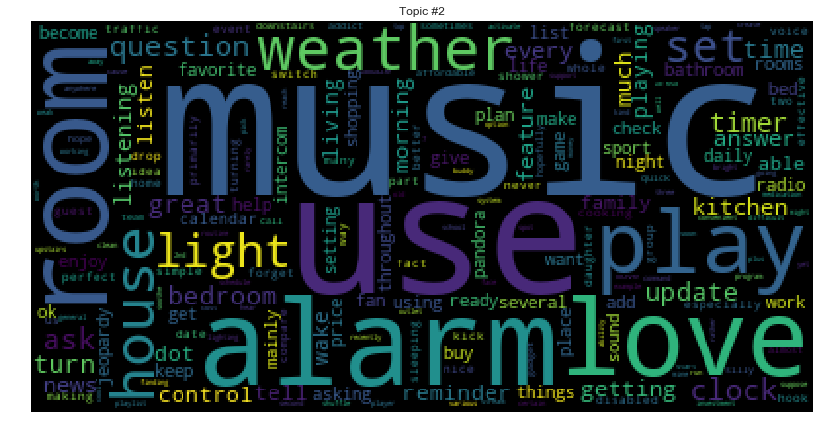

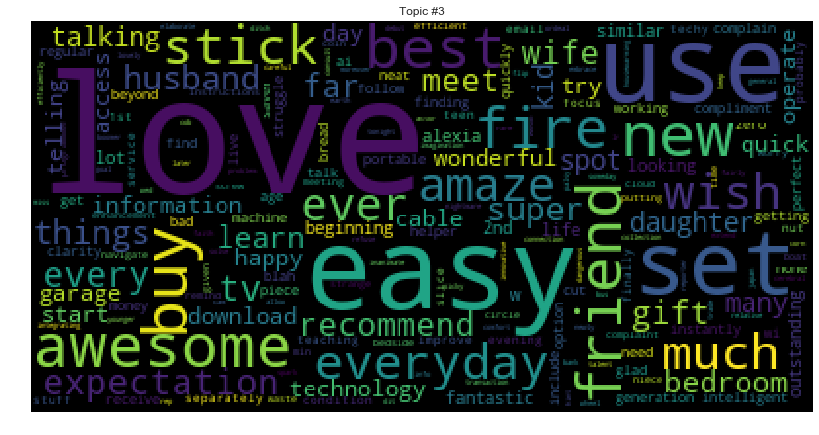

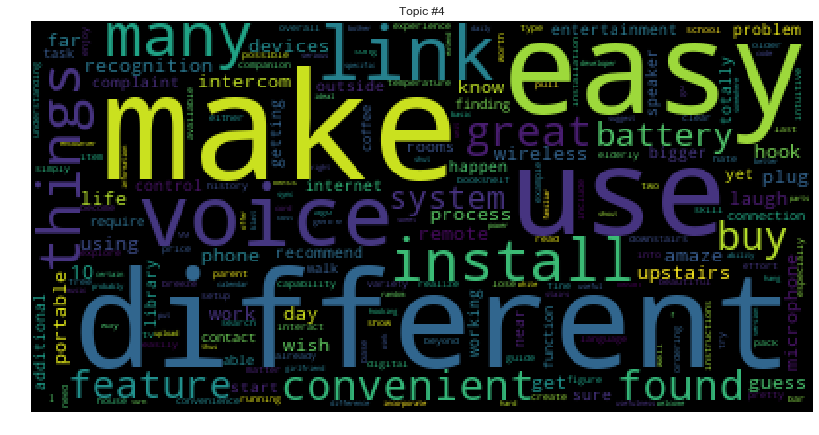

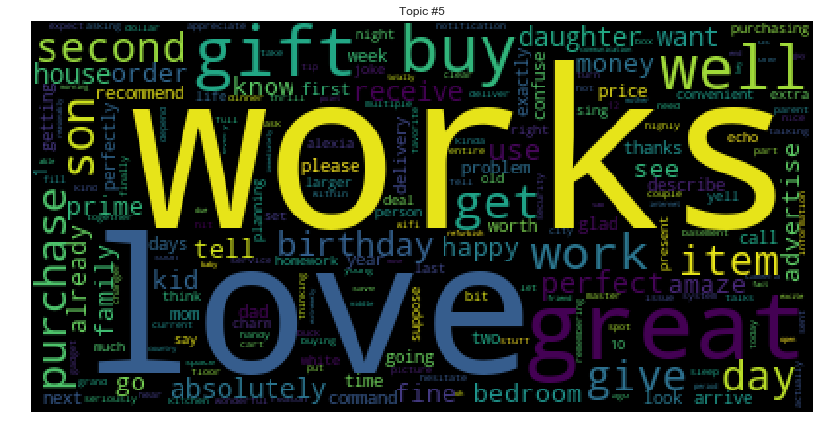

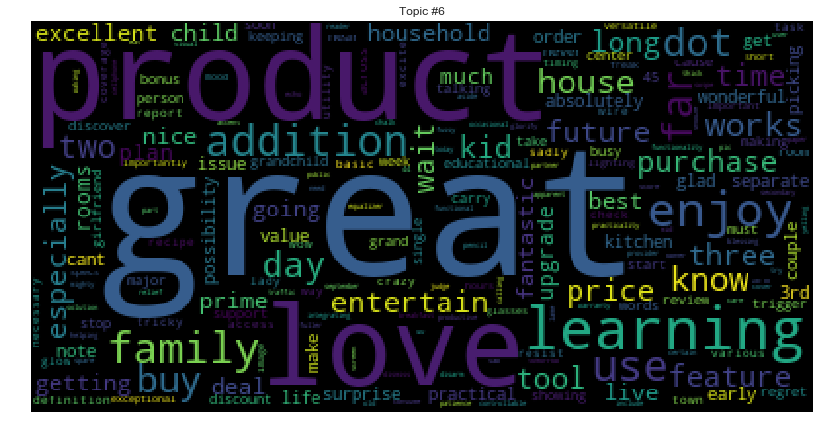

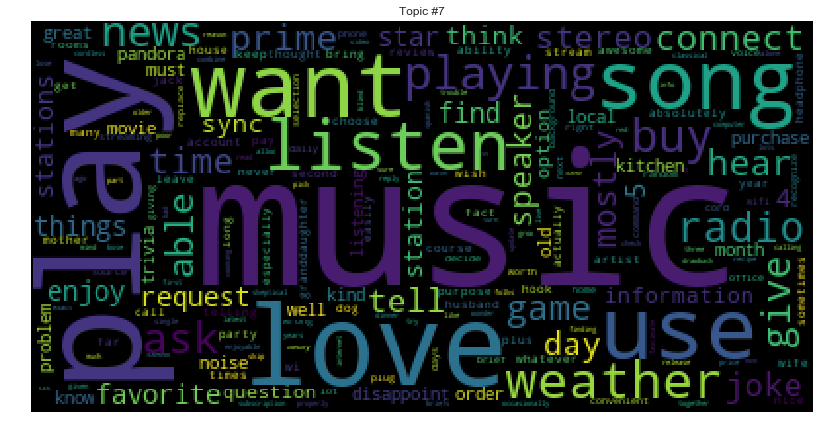

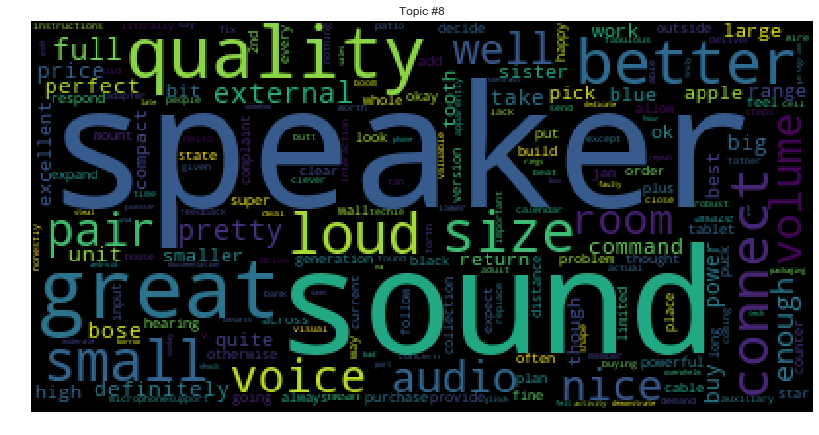

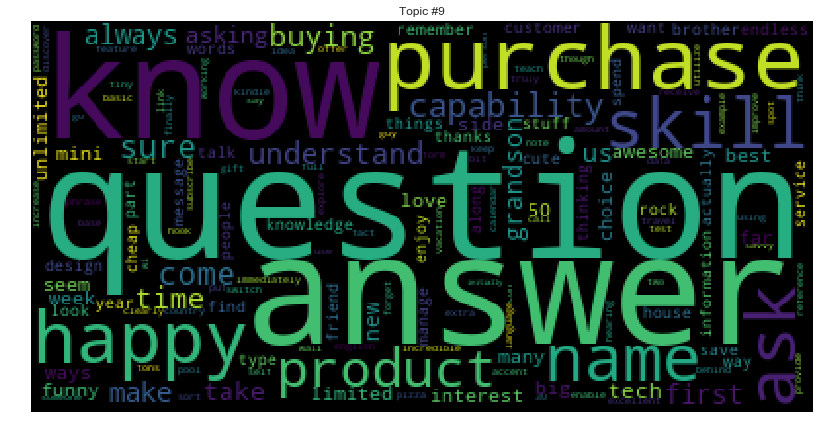

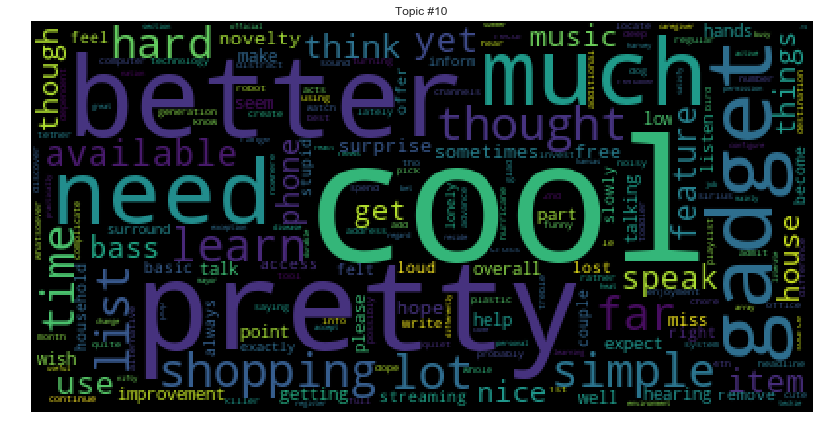

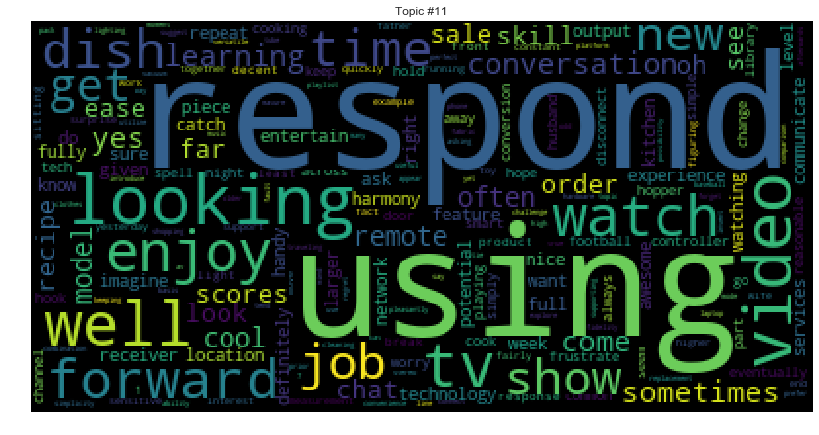

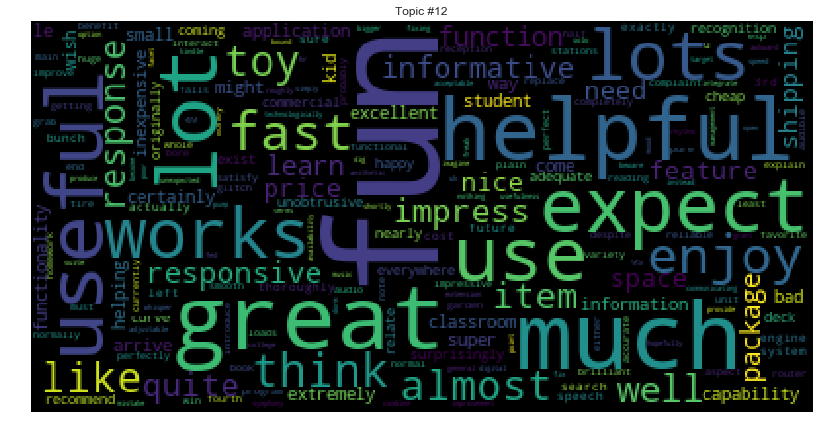

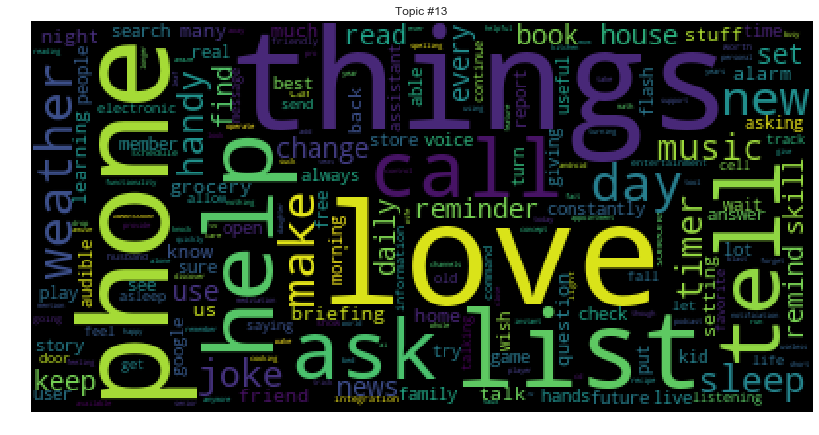

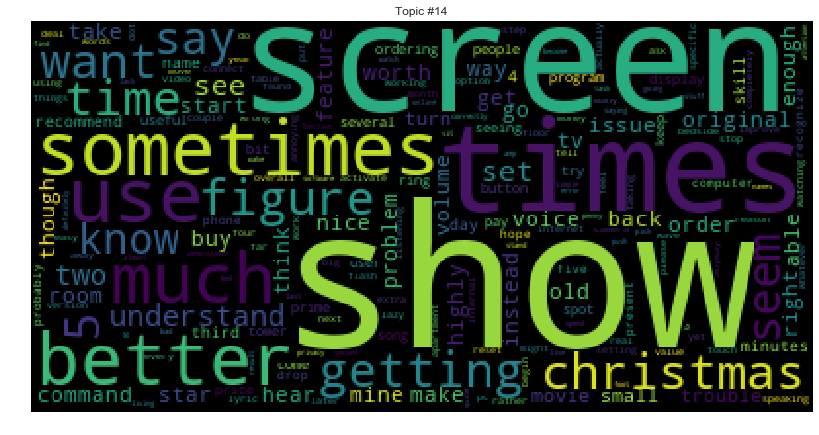

In [99]:
topics_pos15.word_cloud(num_of_topics=15)

In [100]:
# This is to load pickle file if data is available,
# or store data when pickle file isn't available

pkl_path = '/Users/xzhou/github/project_files/amazon/amazon_topic_modeling.pkl'

try:    
    with open(pkl_path, 'rb') as pkl_file:
        topics_neg10 = pickle.load(pkl_file)
        topics_neg15 = pickle.load(pkl_file)
        topics_pos10 = pickle.load(pkl_file)
        topics_pos15 = pickle.load(pkl_file)
except:
    with open(pkl_path, 'wb') as pkl_file:
        pickle.dump(topics_neg10, pkl_file)
        pickle.dump(topics_neg15, pkl_file)
        pickle.dump(topics_pos10, pkl_file)
        pickle.dump(topics_pos15, pkl_file)